<a href="https://colab.research.google.com/github/Neiouo/Eric/blob/main/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80_%E4%BD%9C%E6%A5%AD%E5%9B%9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === 安裝套件（只需執行一次）===
!pip install jieba wordcloud plotly -q
!apt-get update -qq
!apt-get install -y fonts-wqy-zenhei

# === 載入套件 ===
import jieba
import pandas as pd
import re
from collections import Counter
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

使用欄位進行分析：Date,Content


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 38642 (\N{CJK UNIFIED IDEOGRAPH-96F2}) missing from font(s) DejaVu Sans.



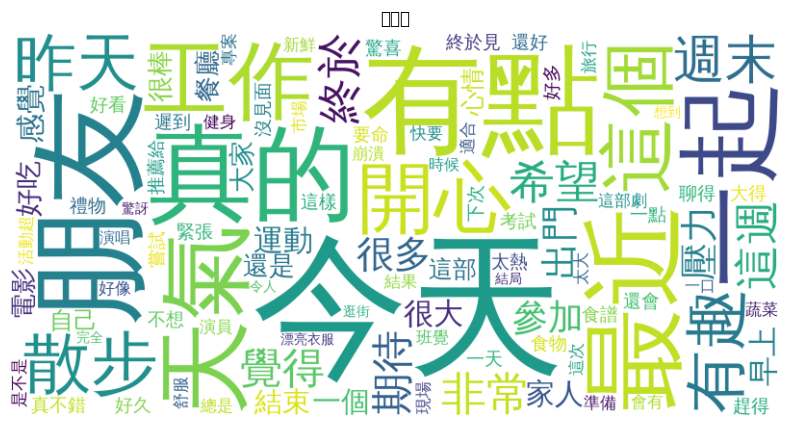

⚠️ 找不到 Date 欄位，自動補上模擬日期


In [5]:
# === 嘗試讀取檔案，並處理常見編碼問題 ===
try:
    df = pd.read_csv('/content/data.csv', encoding='utf-8-sig')
except:
    df = pd.read_csv('/content/data.csv', encoding='big5')



# === 自動找出留言欄位 ===
possible_text_cols = [col for col in df.columns if any(k in col.lower() for k in ['content', '留言', '內容', 'text'])]
text_col = possible_text_cols[0] if possible_text_cols else df.columns[1]
print(f"使用欄位進行分析：{text_col}")

# === 清理文字：只保留中文 ===
def extract_chinese(text):
    return ''.join(re.findall(r'[\u4e00-\u9fa5]', str(text)))

df['Cleaned_Content'] = df[text_col].apply(extract_chinese)

# === Jieba 斷詞 ===
df['Tokenized'] = df['Cleaned_Content'].apply(lambda x: list(jieba.cut(x)))

# === 停用詞列表 ===
stop_words = set(['的', '了', '我', '有', '也', '很', '不', '在', '你', '他', '她', '是', '啊', '呢', '就', '都', '還', '會', '跟', '而且'])

# === 詞頻統計 ===
all_words = [word for tokens in df['Tokenized'] for word in tokens if len(word) > 1 and word not in stop_words]
word_counts = Counter(all_words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# === 詞頻長條圖 ===
fig = px.bar(word_freq_df.head(20), x='Word', y='Frequency',
             title='詞頻統計（前20名）', labels={'Word': '詞語', 'Frequency': '頻率'}, text='Frequency')
fig.show()

# === 文字雲圖 ===
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc',
                      width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(dict(word_freq_df.head(100).values))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("文字雲")
plt.show()

# === 處理日期欄位，並繪製討論熱度趨勢圖 ===
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
else:
    # 自動補日期（假設每 5 筆為一天）
    df['Date'] = [datetime(2025, 4, 1) + timedelta(days=i//5) for i in range(len(df))]
    print("⚠️ 找不到 Date 欄位，自動補上模擬日期")

# === 討論熱度折線圖 ===
daily_counts = df.groupby('Date').size().reset_index(name='Discussion_Count')
fig = px.line(daily_counts, x='Date', y='Discussion_Count',
              title='每日討論熱度趨勢', markers=True)
fig.show()
